# Entrenamiento de un modelo de Cross Selling
* Universo: Clientes de un banco
* Objetivo: Predecir que clientes van a comprar un paquete 

In [1]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv('./data.csv', sep='|', dtype={'client_id':np.int64})
data.dtypes

In [ ]:
data.shape

In [ ]:
data.head(5).T

In [ ]:
data.columns

# 1. Seleccion de Universo y Target

### CU: Take only clients with 9 Months of Data

In [ ]:
data['Month'].value_counts().reset_index()

In [ ]:
# Agrupo los clientes por mes
months = data.groupby('client_id')['Month'].agg([np.count_nonzero],).reset_index()
months.count_nonzero.value_counts().reset_index()

In [ ]:
# Genero el df de clientes con 9 meses de antiguedad
df_clients_with_nine_month_data = months[months.count_nonzero == 9][['client_id']].drop_duplicates().copy()
df_clients_with_nine_month_data.shape

### CU: Take only clients without Active Package
#### Universe windows
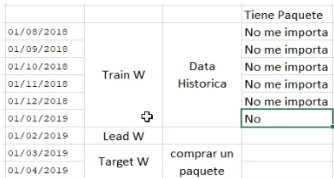

In [ ]:
# Clientes del ultimo mes de train
df_last_month_of_train = data[data['Month'] == '2019-01-01'][['client_id', 'Package_Active', 'Month', 'Target']]
df_last_month_of_train.shape

In [ ]:
# Genero el df de clientes sin conbranding del ultimo mes de train
df_last_month_of_train_no_cobrand = data[(data['Month'] == '2019-01-01') & (data['CreditCard_CoBranding'] == 'No')][['client_id']]
df_last_month_of_train_no_cobrand.shape

In [ ]:
# Genero el df de clientes sin paquetes activos del ultimo mes de train
df_last_month_of_train_no_package = data[(data['Month'] == '2019-01-01') & (data['Package_Active'] == 'No')][['client_id']]
df_last_month_of_train_no_package.shape

In [ ]:
# Genero el universo: clientes con 9 meses de datos, sin paquete activo y sin cobranding en 2019-01-01
universe = df_clients_with_nine_month_data.merge(df_last_month_of_train_no_package, how='inner', on='client_id')\
                                        .merge(df_last_month_of_train_no_cobrand, how='inner', on='client_id')\
                                        .drop_duplicates()

print(f"UNIVERSO: {universe.shape}")

### CU: Getting Target

In [ ]:
# Todos los datos del .csv
data.shape

In [ ]:
# Datos filtrados con el universo
data_universe = data.merge(universe, how='inner', on='client_id')
data_universe.shape

In [ ]:
data_universe.Month.value_counts()

In [ ]:
target_universe = data_universe[(data_universe.Month.isin(['2019-03-01', '2019-04-01'])) & (data_universe.Target == 1)][['client_id']].drop_duplicates()
target_universe.shape

In [ ]:
target_universe['TGT'] = 1
target_universe.shape

In [ ]:
target = universe.merge(target_universe, how='left', on='client_id').fillna(0)
target.TGT.value_counts().reset_index()

In [ ]:
total = target.TGT.count()
objetivo = target[target.TGT == 1.0].TGT.count()
obj_porcentaje = round((objetivo/total) * 100, 2)
print(f"TOTAL: {total} - OBJETIVO: {objetivo} ({obj_porcentaje}%)")

# 2. Preprocesamiento y Transformación

In [ ]:
# Genero el df de la ventana de entrenamiento
training_window_universe = data_universe[data_universe.Month.isin(['2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'])]
training_window_universe.Month.value_counts().reset_index()

### CU: Find Data Types

In [ ]:
training_window_universe.info()

In [ ]:
training_window_universe.dtypes.value_counts().reset_index()

### CU: Find Identity Feature

In [ ]:
# Genero los posibles identity features del ultimo mes del training window
identity_features = training_window_universe[training_window_universe.Month == '2019-01-01']\
    [['client_id', 'First_product_dt', 'Last_product_dt', 'Month',
      'CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active',
      'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
      'DebitCard_Active', 'Investment_Active',
      'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
      'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product',
      'Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking', 'Operations_Mobile', 'Operations_Ivr',
      'Operations_Telemarketer', 'Operations_ATM']]

identity_features.shape

In [ ]:
# Se eliminan los identity features del universo
training_window_universe.drop(['First_product_dt', 'Last_product_dt', 'Month',
      'CreditCard_Premium', 'CreditCard_Active', 'Loan_Active', 'Mortgage_Active',
      'SavingAccount_Active_ARG_Salary', 'SavingAccount_Active_ARG', 'SavingAccount_Active_DOLLAR',
      'DebitCard_Active', 'Investment_Active',
      'Insurance_Life', 'Insurance_Home', 'Insurance_Accidents', 'Insurance_Mobile', 'Insurance_ATM', 'Insurance_Unemployment',
      'Sex', 'Client_Age_grp', 'Mobile', 'Email', 'Region', 'CreditCard_Product',
      'Operations_Bank', 'Operations_Terminal', 'Operations_HomeBanking', 'Operations_Mobile', 'Operations_Ivr',
      'Operations_Telemarketer', 'Operations_ATM'], inplace=True, axis=1)
training_window_universe.shape

### CU: Find Transform Features

In [ ]:
# Ejemplo de transform feature
identity_features.Client_Age_grp.value_counts().reset_index()

In [ ]:
# Transformo los rangos de edad a valores ordinales
ages_dict = {
    'Entre 18 y 29 años': 1,
    'Entre 30 y 39 años': 2,
    'Entre 40 y 49 años': 3,
    'Entre 50 y 59 años': 4,
    'Entre 60 y 64 años': 5,
    'Entre 65 y 69 años': 6,
    'Mayor a 70 años': 7,
}

identity_features['Client_Age_grp_ordinal'] = identity_features['Client_Age_grp'].map(ages_dict)
identity_features['Client_Age_grp_ordinal'].value_counts().reset_index()

In [ ]:
# Generacion de nuevas features (suma de features)
identity_features['Active_Insurance'] = np.where(identity_features.Insurance_Life == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Home == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Accidents == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Mobile == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_ATM == 'Yes', 1, 0) \
    + np.where(identity_features.Insurance_Unemployment == 'Yes', 1, 0)

identity_features['Active_Insurance'].value_counts().reset_index()

In [ ]:
identity_features['Active_Products'] = np.where(identity_features.Loan_Active == 'Yes', 1, 0) \
    + np.where(identity_features.CreditCard_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Mortgage_Active == 'Yes', 1, 0) \
    + np.where(identity_features.SavingAccount_Active_ARG == 'Yes', 1, 0) \
    + np.where(identity_features.SavingAccount_Active_DOLLAR == 'Yes', 1, 0) \
    + np.where(identity_features.DebitCard_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Investment_Active == 'Yes', 1, 0) \
    + np.where(identity_features.Active_Insurance > 0, 1, 0)

identity_features['Active_Products'].value_counts().reset_index()


In [29]:
# Como ningun cliente tiene seguros activos, no tiene sentido tener este feature
identity_features.drop(['Active_Insurance'], inplace=True, axis=1)

In [ ]:
# Transformacion de fechas

# Primero paso fechas de tipo object a fechas de tipo datetime para poder operar
identity_features['First_product_dt'] = pd.to_datetime(identity_features['First_product_dt'])
identity_features['Last_product_dt'] = pd.to_datetime(identity_features['Last_product_dt'])
identity_features['Month'] = pd.to_datetime(identity_features['Month'])

identity_features[['Month']].dtypes

In [ ]:
identity_features['Months_From_First_Product'] = (identity_features['Month'] - identity_features['First_product_dt']).dt.days / 30
identity_features['Months_From_First_Product'].value_counts().reset_index()

In [ ]:
identity_features['Months_From_First_Last_Product'] = (identity_features['Last_product_dt'] - identity_features['First_product_dt']).dt.days / 30
identity_features['Months_From_First_Last_Product'].value_counts().reset_index()

In [ ]:
identity_features['Months_From_Last_Product'] = (identity_features['Month'] - identity_features['Last_product_dt']).dt.days / 30
identity_features['Months_From_Last_Product'].value_counts().reset_index()

In [ ]:
identity_features[['First_product_dt', 'Last_product_dt', 'Month', 'Months_From_First_Product', 'Months_From_First_Last_Product', 'Months_From_Last_Product']]

In [ ]:
# Se cambia los meses con valores negativos a ceros
print(f"Existen meses en negativo: {any(ele < 0 for ele in identity_features['Months_From_Last_Product'])}")

identity_features['Months_From_First_Product'] = np.where(identity_features['Months_From_First_Product'] < 0, 0, identity_features['Months_From_First_Product'])
identity_features['Months_From_First_Last_Product'] = np.where(identity_features['Months_From_First_Last_Product'] < 0, 0, identity_features['Months_From_First_Last_Product'])
identity_features['Months_From_Last_Product'] = np.where(identity_features['Months_From_Last_Product'] < 0, 0, identity_features['Months_From_Last_Product'])

identity_features[['First_product_dt', 'Last_product_dt', 'Month', 'Months_From_First_Product', 'Months_From_First_Last_Product', 'Months_From_Last_Product']]

In [36]:
# Se eliminan las fechas como tal
identity_features.drop(['First_product_dt', 'Last_product_dt', 'Month'], inplace=True, axis=1)

In [ ]:
# Se agrega la transform feature de Operationes totales
identity_features['Operations_Total'] = identity_features.Operations_Bank + identity_features.Operations_Terminal +\
    identity_features.Operations_HomeBanking + identity_features.Operations_Mobile + identity_features.Operations_Ivr +\
    identity_features.Operations_Telemarketer + identity_features.Operations_ATM
identity_features['Operations_Total'].value_counts().reset_index()

In [ ]:
# Se agrega la transform feature de Canales digitales y fisicos
identity_features['Digital_Channels'] = identity_features.Operations_HomeBanking + identity_features.Operations_Mobile +\
    identity_features.Operations_Ivr + identity_features.Operations_Telemarketer

identity_features['Physical_Channels'] = identity_features.Operations_Bank + identity_features.Operations_Terminal + identity_features.Operations_ATM

identity_features[['Digital_Channels', 'Physical_Channels']].value_counts().reset_index()

In [ ]:
# Se agrega la transform feature de HomeBanking vs Mobile
identity_features['Operations_HomeBanking_vs_Mobile'] = np.where(identity_features['Operations_Mobile'] == 0,
                                                       identity_features.Operations_HomeBanking,
                                                       identity_features.Operations_HomeBanking / identity_features.Operations_Mobile)

identity_features['Operations_HomeBanking_vs_Mobile'].value_counts().reset_index()

### CU: Find Missing Values

In [ ]:
identity_features.columns

In [ ]:
# Busco columnas con nulos en los features
identity_features.columns[identity_features.isnull().any()].tolist()

In [42]:
# Elimino Region
identity_features.drop(['Region'], inplace=True, axis=1)

In [ ]:
# Existen tarjetas de creditos activos?
identity_features['CreditCard_Active'].value_counts().reset_index()

In [ ]:
# Como existen CreditCard_Active, tiene que existir CreditCard_Product. Una opcion es traer los datos de otra ventana,
# ya que no es un dato que cambie mucho en el tiempo
data.groupby(['Month', 'CreditCard_Product']).size()

In [45]:
cc_product = data[data.Month == '2019-03-01'].groupby(['client_id', 'CreditCard_Product']).size().reset_index()

In [46]:
identity_features.drop(['CreditCard_Product'], inplace=True, axis=1)

In [ ]:
identity_features = identity_features.merge(cc_product[['client_id', 'CreditCard_Product']], how='left', on='client_id')
identity_features.groupby(['CreditCard_Active', 'CreditCard_Product']).size()

In [ ]:
# No puede existir CreditCard_Product sin CreditCard_Active. Se limpia el dato
identity_features['CreditCard_Product'] = np.where(identity_features.CreditCard_Active == 'No', 'No', identity_features.CreditCard_Product)
identity_features.groupby(['CreditCard_Active', 'CreditCard_Product']).size()

In [49]:
#identity_features.columns[identity_features.isnull().any()].tolist()
#identity_features[identity_features.CreditCard_Product.isnull()][['client_id']]

In [ ]:
identity_features.CreditCard_Product.value_counts().reset_index()

In [ ]:
# Busco nulos en el universo del training window
training_window_universe.columns[training_window_universe.isnull().any()].tolist()

In [ ]:
training_window_universe[training_window_universe.SavingAccount_Balance_Average.isnull()][['client_id', 'SavingAccount_Balance_Average',
                                                                    'SavingAccount_Balance_FirstDate', 'SavingAccount_Balance_LastDate']]

In [ ]:
training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe.SavingAccount_Balance_Average.isnull(),
                training_window_universe.SavingAccount_Balance_FirstDate + training_window_universe.SavingAccount_Credits_Amounts - training_window_universe.SavingAccount_Debits_Amounts,
                training_window_universe.SavingAccount_Balance_Average)

training_window_universe.columns[training_window_universe.isnull().any()].tolist()

### CU: Analyze Outliers

In [ ]:
training_window_universe['SavingAccount_Balance_Average'].describe()

In [ ]:
# Grafico: Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(training_window_universe['SavingAccount_Balance_Average'], kind='kde')

plt.show()

In [ ]:
# Grafico: Box Plot
plt.boxplot(training_window_universe['SavingAccount_Balance_Average'])

plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].min(), s='min')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].quantile(0.25), s='Q1')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].median(), s=' median (Q2)')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].quantile(0.75), s='Q3')
plt.text(x=1.1, y=training_window_universe['SavingAccount_Balance_Average'].max(), s='max')

plt.title('Monto total de factura')
plt.ylabel('Factura total')

In [ ]:
# Elimino los valores menores a 50
SA_Balance_Average_gt_50 = training_window_universe[training_window_universe['SavingAccount_Balance_Average'] > 50]
SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].describe()

In [ ]:
# Entre el 75% y el max hay mucha diferencia. Analizo P95, P99 y 3*sigma
p95 = SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].quantile(0.95)
p99 = SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].quantile(0.99)
sigma_3 = 3 * SA_Balance_Average_gt_50['SavingAccount_Balance_Average'].std()

print(f"P95: {p95} - P99: {p99} - 3*sigma: {sigma_3}")

In [ ]:
# Elijo el tratamiento de outliers: p95
training_window_universe['SavingAccount_Balance_Average'] = np.where(training_window_universe['SavingAccount_Balance_Average'] < p95,
                                                                     training_window_universe['SavingAccount_Balance_Average'],
                                                                     p95)

training_window_universe['SavingAccount_Balance_Average'].describe()

### CU: Aggregate Features

In [ ]:
training_window_universe.columns

In [ ]:
cols_to_aggregate = [x for x in training_window_universe if x not in (['client_id', 'Target', 'Package_Active', 'CreditCard_CoBranding'])]
len(cols_to_aggregate)

In [ ]:
aggregate_features = training_window_universe.groupby(['client_id'])[cols_to_aggregate].agg([np.sum, np.amax, np.min, np.mean, 
                                                                                            np.median, np.count_nonzero, 'nunique', np.var])


In [ ]:
aggregate_features.columns = ['_'.join(x) for x in np.array(aggregate_features.columns)]
aggregate_features.head(1).T

### CU: Create the Analytic Base Table

In [ ]:
ABT = target.merge(identity_features, how='inner', on='client_id')\
    .merge(aggregate_features, how='inner', on='client_id')

ABT.shape

# 3. Reducción de dimensionalidad

### CU: Unique Values

In [ ]:
# Elimino los features con valores min == max
abt_desc = pd.DataFrame(ABT.describe().T)

min_eq_max = abt_desc[abt_desc['min'] == abt_desc['max']].reset_index()
print("Min == Max: ", min_eq_max.shape)

ABT.drop(min_eq_max['index'], inplace=True, axis=1)
print("ABT: ", ABT.shape)

### CU: Correlation Matrix

In [ ]:
# Ejemplo de matriz de correlacion
corr = ABT[['SavingAccount_ATM_Extraction_Transactions_sum',
 'SavingAccount_ATM_Extraction_Transactions_amax',
 'SavingAccount_ATM_Extraction_Transactions_min',
 'SavingAccount_ATM_Extraction_Transactions_mean',
 'SavingAccount_ATM_Extraction_Transactions_median',
 'SavingAccount_ATM_Extraction_Transactions_count_nonzero',
 'SavingAccount_ATM_Extraction_Transactions_nunique',
 'SavingAccount_ATM_Extraction_Transactions_var',]].corr()

corr

In [ ]:
sns.heatmap(corr, annot=True)

In [ ]:
# Elimino de la ABT las columnas que tengan una correlacion mayor a 0.85
# Nota: primero elimino aquellas variables que no son numericas, client_id y TGT
abt_corr = ABT.drop(['client_id',
 'TGT',
 'CreditCard_Premium',
 'CreditCard_Active',
 'Loan_Active',
 'Mortgage_Active',
 'SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'DebitCard_Active',
 'Investment_Active',
 'Insurance_Life',
 'Insurance_Home',
 'Insurance_Accidents',
 'Insurance_Mobile',
 'Insurance_ATM',
 'Insurance_Unemployment',
 'Sex',
 'Client_Age_grp',
 'Mobile',
 'Email',
 'CreditCard_Product'], axis=1).corr().abs()

upper_abt_corr = abt_corr.where(np.triu(np.ones(abt_corr.shape), k=1).astype(np.bool)).fillna(0)

corr_gt_85 = [col for col in upper_abt_corr.columns if any(upper_abt_corr[col] > 0.85)]

#print(corr_gt_85)

ABT.drop(corr_gt_85, inplace=True, axis=1)
ABT.shape

### CU: PCA (Opcional)

In [ ]:
cols = [x for x in ABT.columns if x.startswith('CreditCard_Spending')]
cols

In [ ]:
# Paso 1: Estandarizar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(ABT[cols]) # entrena y transforma las columnas de ABT

df_data_scaled = pd.DataFrame(data_scaled, columns=ABT[cols].columns)

data_scaled.shape

In [71]:
# Paso 2: Componentes principales
from sklearn.decomposition import PCA

n = df_data_scaled.shape[1]

pca = PCA(n_components=n, random_state=1)
df_pca = pd.DataFrame(pca.fit_transform(df_data_scaled))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.plot(range(1, n + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Variacion de componentes")
plt.xlabel("Cantidad de componentes")
plt.ylabel("Varianza acumulada")

### CU: Get the most important features

In [73]:
# Paso 1: Eliminar features correlacionados -> Realizado en "CU: Correlation Matrix"

In [ ]:
# Paso 2: Transformar features categoricos
# Nota: Por ahora descarto los features categoricos hasta que los transforme
ABT_Model = ABT.drop([
 'CreditCard_Premium',
 'CreditCard_Active',
 'Loan_Active',
 'Mortgage_Active',
 'SavingAccount_Active_ARG_Salary',
 'SavingAccount_Active_ARG',
 'SavingAccount_Active_DOLLAR',
 'DebitCard_Active',
 'Investment_Active',
 'Insurance_Life',
 'Insurance_Home',
 'Insurance_Accidents',
 'Insurance_Mobile',
 'Insurance_ATM',
 'Insurance_Unemployment',
 'Sex',
 'Client_Age_grp',
 'Mobile',
 'Email',
 'CreditCard_Product'], axis=1)
ABT_Model.shape

In [ ]:
# Paso 3: Estandarizacion
cols = [x for x in ABT_Model.columns if (x != 'client_id') and (x != 'TGT')]

scaler = StandardScaler(copy=True)
scaler.fit(ABT_Model[cols])

std_transform = scaler.transform(ABT_Model[cols])
df_std_transform = pd.DataFrame(std_transform, columns=cols, index=ABT_Model.index)

ABT_Model.drop(cols, inplace=True, axis=1)
ABT_Model = pd.concat((ABT_Model, df_std_transform), axis=1, sort=False)

ABT_Model.head(10)

# 4. Modelado

In [ ]:
# Paso 4: Entrenar un modelo (Random forest, lightgbm, etc) por cada dimension

target_column = 'TGT'
cols = [x for x in ABT_Model.columns if (x != 'client_id') & (x != 'TGT')]

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

fit_params = {
    #"early_stopping_rounds": 100,
    "eval_metric": "auc", # como metrica se usa la ROC
    "eval_set": [(ABT_Model[cols], ABT_Model[target_column])],
    #"verbose": 100
}

test_params = {
    "num_leaves": np.arange(10, 20, 1),
    "min_data_in_leaf": np.arange(1000, 3000, 100),
    "subsample": sp_uniform(loc=0.2, scale=0.8),
    "max_depth": np.arange(6, 10, 1),
    "n_estimators": np.arange(15, 20, 1)
}

hp_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

classifier = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', nfold=5, n_jobs=4)

rs = RandomizedSearchCV(estimator=classifier, param_distributions=test_params, n_iter=hp_points_to_test, 
                        scoring='roc_auc', cv=3, refit=True, random_state=314, verbose=True)

# Se entrena con el 100% de la muestra, no se divide el dataset
x_train = ABT_Model[cols]
y_train = ABT_Model[target_column]

rs.fit(x_train, y_train, **fit_params)

feature_importances = pd.Series(rs.best_estimator_.feature_importances_, index=ABT_Model[cols].columns)
feature_importances.nlargest(50).plot(kind='barh', figsize=(8, 10))




In [ ]:
# Obtengo las 30 variables mas importantes
df_feature_importances = feature_importances.nlargest(30).reindex()
df_feature_importances

In [ ]:
# Reentreno el modelo con las variables mas importantes

target_column = 'TGT'
cols = [x for x in df_feature_importances.keys()]

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

fit_params = {
    #"early_stopping_rounds": 100,
    "eval_metric": "auc", # como metrica se usa la ROC
    "eval_set": [(ABT_Model[cols], ABT_Model[target_column])],
    #"verbose": 100
}

test_params = {
    "num_leaves": np.arange(10, 20, 1),
    "min_data_in_leaf": np.arange(1000, 3000, 100),
    "subsample": sp_uniform(loc=0.2, scale=0.8),
    "max_depth": np.arange(6, 10, 1),
    "n_estimators": np.arange(15, 20, 1)
}

hp_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

classifier = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', nfold=5, n_jobs=4)

rs = RandomizedSearchCV(estimator=classifier, param_distributions=test_params, n_iter=hp_points_to_test, 
                        scoring='roc_auc', cv=3, refit=True, random_state=314, verbose=True)

# Se entrena con el 100% de la muestra, no se divide el dataset
x_train = ABT_Model[cols]
y_train = ABT_Model[target_column]

rs.fit(x_train, y_train, **fit_params)

feature_importances = pd.Series(rs.best_estimator_.feature_importances_, index=ABT_Model[cols].columns)
feature_importances.nlargest(30).plot(kind='barh', figsize=(8, 10))

In [ ]:
df_feature_importances = feature_importances.nlargest(30).reindex()
df_feature_importances

### CU: Bivariate Analysis

#### Graficos

In [125]:
# Abrir el archivo graficos_v2.py y cambien la ruta de los directorios de la funcion Graficar_Variables2

# Para importar la libreria
%run ./graficos_v2.py 

# Para que funcione tienen que tener un campo idx y un campo TGT (TGT es el target 1 o 0)
ABT_Model['idx'] = ABT_Model['client_id']
ABT['idx'] = ABT['client_id']

In [126]:
# Crear el pdf de las variables que estan en vars
cols = [x for x in df_feature_importances.keys()]

vars = ['idx', 'TGT'] + cols
#Graficar_Variables2(ABT_Model[vars], [], 'TGT')

In [ ]:
# Paso 5: Seleccionar las mejores variables
selected_features = list(df_feature_importances.keys()) + ['client_id', 'TGT']
selected_features

### CU: Split train and test


In [ ]:
ABT_Model_Selected = ABT_Model[selected_features].copy()
ABT_Model_Selected.shape

In [141]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(ABT_Model_Selected, test_size=0.3, random_state=42, stratify=ABT_Model_Selected['TGT'])

In [ ]:
x_train.TGT.value_counts()

In [ ]:
x_test.TGT.value_counts()

In [ ]:
# Entrenar el modelo solo con x_train y evaluarlo con x_test

target_column = 'TGT'
cols = list(df_feature_importances.keys())

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold

fit_params = {
    #"early_stopping_rounds": 100,
    "eval_metric": 'auc', # como metrica se usa la ROC
    "eval_set": [(x_test[cols], x_test[target_column])],
    #"verbose": 100
}

test_params = {
    "num_leaves": np.arange(3, 8, 1),
    "min_child_samples": np.arange(300, 500, 100),
    "max_depth": np.arange(4, 10, 1),
    "n_estimators": np.arange(6, 20, 1),
    "learning_rate": [0.05, 0.1, 0.2, 0.01],
}

hp_points_to_test = 50


classifier = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', n_jobs=4)

cross_validation = StratifiedKFold(n_splits=3)

rs = RandomizedSearchCV(estimator=classifier, param_distributions=test_params, n_iter=hp_points_to_test, 
                        scoring='roc_auc', cv=cross_validation, refit=True, random_state=314, verbose=True)

# Se entrena con el 100% de la muestra, no se divide el dataset
#x_train = x_train[cols]
#y_train = x_train[target_column]

rs.fit(x_train[cols], x_train[target_column], **fit_params)

feature_importances = pd.Series(rs.best_estimator_.feature_importances_, index=x_train[cols].columns)
feature_importances.nlargest(70).plot(kind='barh', figsize=(8, 10))


In [ ]:
# Obtengo los mejores hiperparametros
optimal_parameters = rs.best_estimator_.get_params()
print(optimal_parameters)
print(rs.best_estimator_)

In [ ]:
# Genero el modelo con los mejores parametros
final_classifier = lgb.LGBMClassifier(**classifier.get_params())
final_classifier.set_params(**optimal_parameters)

final_fit = final_classifier.fit(x_train[cols], x_train[target_column], **fit_params)
print(final_fit.best_score_)

feature_importances = pd.Series(final_classifier.feature_importances_, index=x_train[cols].columns)
feature_importances.nlargest(100).plot(kind='barh', figsize=(8, 10))